In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH, FIGURES_PATH
from experiments.utils.parser import AdaptationParser
import experiments.utils.drawing

In [2]:
metaserieses = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
serieses = [1, 2, 3, 21, 22, 23, 41, 42, 43, 61, 62, 63, 81, 82, 83]

series_meta = {
    "Accuracy-priorotize": {
        "video": 1,
        "audio-qa": 21,
        "audio-sent": 41,
        "sum-qa": 61,
        "nlp": 81,
    },
    "Balance": {"video": 2, "audio-qa": 22, "audio-sent": 42, "sum-qa": 62, "nlp": 82},
    "Resource-priorotize": {
        "video": 3,
        "audio-qa": 23,
        "audio-sent": 43,
        "sum-qa": 63,
        "nlp": 83,
    },
}

series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series, metaseries in zip(serieses, metaserieses)
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="nlp", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [3]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    config = configs_exp["0.yaml"]
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

In [4]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [5]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Replica Changes
1. Total
2. Per node

In [6]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]
    # draw_temporal(replica_changes[series], adaptation_intervals[series])
replica_changes_total = {
    key: {"total": value["total"]} for key, value in replica_changes.items()
}
ylabel = "replicas"
# draw_temporal(
#     replica_changes_total, adaptation_intervals, ylabel=ylabel, multiple_experiments=True
# )
# draw_cumulative(replica_changes_total, multiple_experiments=True, ylabel=ylabel)

## Per Container Core changes
1. Total
2. Per Node

In [7]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]
    # draw_temporal(core_changes[series])
ylabel = "core changes"
# draw_temporal(
#     core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
# )
core_changes_total = {
    key: {"total": value["total"]} for key, value in core_changes.items()
}
# draw_cumulative(
#     core_changes_total, multiple_experiments=True, ylabel=ylabel, series_names=series_names
# )

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

In [8]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()
    # draw_temporal(total_core_changes[series])
legend = "Priority"
xlabel = "Pipelines"
ylabel = "Total Core"
# draw_temporal(
#     total_core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
# )

for exp, value in total_core_changes.items():
    value["total"] = (np.array(value["total"]) / len(value["total"])).tolist()

total_core_changes_total = {
    key: value["total"] for key, value in total_core_changes.items()
}

## Accuracy Changes

In [9]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [
            sum(x) for x in zip(*accuracy_changes[series].values())
        ]
    # draw_temporal(accuracy_changes[series])
ylabel = "Accuracy"

accuracy_changes_total = {key: value["e2e"] for key, value in accuracy_changes.items()}

# make it average
for exp, value in accuracy_changes_total.items():
    accuracy_changes_total[exp] = (np.array(value) / len(value)).tolist()

/home/cc/ipa/experiments/utils/drawing.py:648: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(group_names)


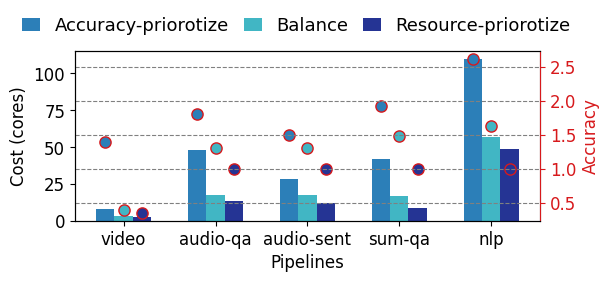

In [10]:
import importlib

importlib.reload(experiments.utils.drawing)

data = {"Cost (cores)": total_core_changes_total, "Accuracy": accuracy_changes_total}


experiments.utils.drawing.draw_objective_preference(
    data,
    series_meta=series_meta,
    xlabel=xlabel,
    filename=f"{FIGURES_PATH}/objective-preferences",
    colors=["#2c7fb8", "#41b6c4", "#253494"],
    bar_width=0.2,
    bbox_to_anchor=(1.1, 1.3),
)